In [1]:
import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [2]:
from keras.optimizers import SGD
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K
from sklearn.metrics import log_loss
from custom_layers.scale_layer import Scale
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split   


def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras

    Model Schema is based on 
    https://github.com/flyyufelix/DenseNet-Keras

    # Returns
        A Keras model instance.
    '''

    # Handle Dimension Ordering for different backends
    global concat_axis
    img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    concat_axis = 3


    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(img_input)
    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, dropout_rate=dropout_rate)
        nb_filter = int(nb_filter)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis )(x)
    x = Activation('relu')(x)

    x_fc = GlobalAveragePooling2D()(x)
    x_fc = Dense(1000)(x_fc)
    x_fc = Activation('softmax')(x_fc)

    model = Model(img_input, x_fc)

    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D()(x)
    x_newfc = Dense(num_classes)(x_newfc)
    x_newfc = Activation('softmax')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model



Using TensorFlow backend.


In [3]:

def conv_block(x, stage, branch, nb_filter, dropout_rate=None):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout '''


    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Convolution2D(inter_channel, 1, 1, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(nb_filter, 3, 3, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, dropout_rate=None):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout  '''


    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(nb_filter), 1, 1, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis)

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


# Implement your own load_data() module for your own dataset

In [4]:
import os

import numpy as np
from keras.utils import np_utils
from keras import backend as K
from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file



def load_data():
  data=[]
  labels=[]
  random.seed(42)
  imagePaths = sorted(list(os.listdir("dataset")))
  random.shuffle(imagePaths)
  print(imagePaths)

  for img in imagePaths:
    path=sorted(list(os.listdir("dataset/"+img)))
    for i in path:
        image = cv2.imread("dataset/"+img+'/'+i)
        image = cv2.resize(image, (224,224))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)
  data = np.array(data, dtype="float32") / 255.0
  labels = np.array(labels)
  mlb = LabelBinarizer()
  labels = mlb.fit_transform(labels)
  #print(labels[0])

  (xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.25,random_state=42)
  #print(xtrain.shape, xtest.shape)
  return xtrain, ytrain, xtest, ytest

#load_data()

In [5]:
from keras.callbacks import ModelCheckpoint
if __name__ == '__main__':

    # Example to fine-tune on 3000 samples from Cifar10

    img_rows, img_cols = 224, 224 # Resolution of inputs
    channel = 3
    num_classes =4
    batch_size = 16 
    nb_epoch = 10

    # Load Cifar10 data. Please implement your own load_data() module for your own dataset
    X_train, Y_train, X_valid, Y_valid = load_data()

    # Load our model
    model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)
    filepath="bestmodel.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Start Fine-tuning
    history=model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, Y_valid),
              callbacks=callbacks_list,
              )

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # Cross-entropy loss score
    score = log_loss(Y_valid, predictions_valid)

['flower', 'car', 'motorbike', 'airplane']
Train on 2494 samples, validate on 832 samples
Epoch 1/10
2494/2494 [==============================] - 1090s - loss: 0.6016 - acc: 0.7807 - val_loss: 2.1988 - val_acc: 0.2103
Epoch 2/10
2494/2494 [==============================] - 1050s - loss: 0.3113 - acc: 0.8945 - val_loss: 1.5584 - val_acc: 0.5877
Epoch 3/10
2494/2494 [==============================] - 1048s - loss: 0.2209 - acc: 0.9274 - val_loss: 1.9807 - val_acc: 0.5144
Epoch 4/10
2494/2494 [==============================] - 1048s - loss: 0.1895 - acc: 0.9431 - val_loss: 6.7925 - val_acc: 0.3185
Epoch 5/10
2494/2494 [==============================] - 1049s - loss: 0.1531 - acc: 0.9467 - val_loss: 0.4107 - val_acc: 0.8570
Epoch 6/10
2494/2494 [==============================] - 1052s - loss: 0.1447 - acc: 0.9491 - val_loss: 7.3753 - val_acc: 0.3005
Epoch 7/10
2494/2494 [==============================] - 1051s - loss: 0.1106 - acc: 0.9643 - val_loss: 0.6997 - val_acc: 0.7957
Epoch 8/10
249

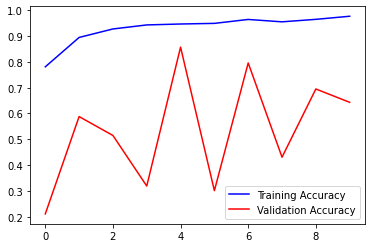

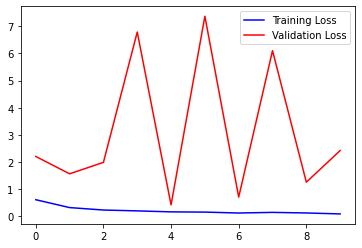

In [6]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [7]:
#X_valid, Y_valid
xtest=X_valid
ytest=Y_valid
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 832 	accurately-predicted-data: 535 	 wrongly-predicted-data:  297
Accuracy: 64.303 %


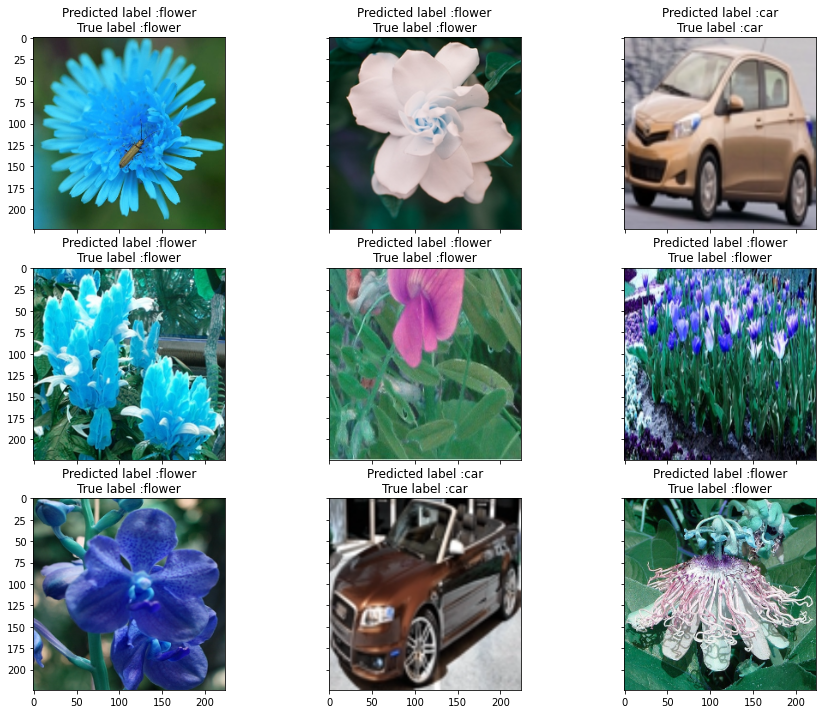

In [8]:
label=['airplane', 'car','flower','motorbike']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

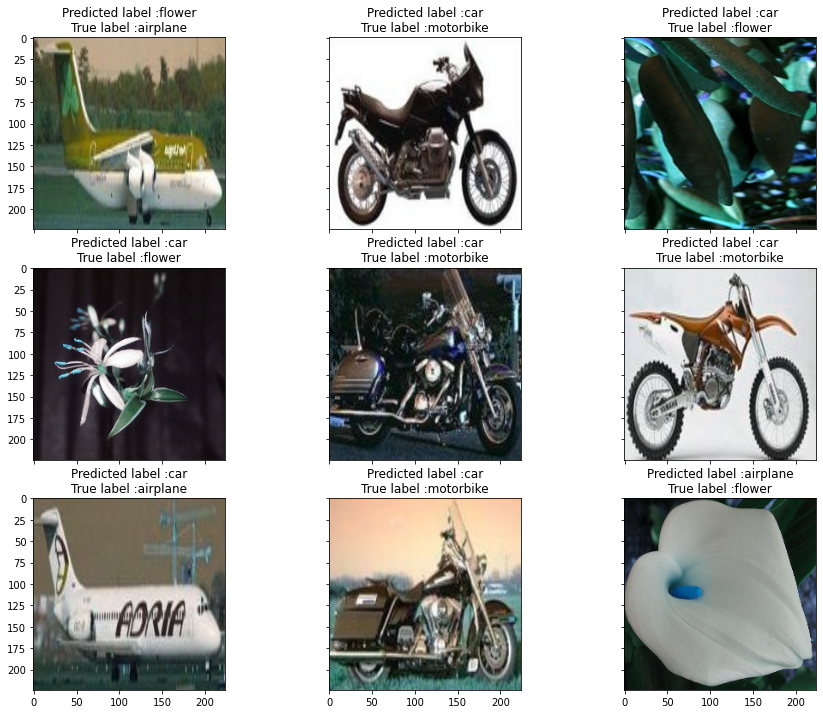

In [16]:
label=['airplane', 'car','flower','motorbike']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

In [19]:
import h5py
from keras.models import load_model
# The model weights (that are considered the best) are loaded into the model.


#model=load_model('bestmodel.hdf5')

#ypred = model.predict(xtest)

